# ECE/CS 498DS Spring 2021
## Final Project : Dota2 Outcome Prediction
### Group Members: Omkar Mehta (omehta2), Yinfei (yinfei2), Anmol (anmola2)

Dota 2 is an online video game in which two teams of five players compete to destroy the ‘Ancient’, a large structure defended by the opposing team, while defending their own. The two teams are known as Radiant and Dire. The Ancients sit in bases in opposite corners of the map that are connected by three paths called ‘lanes’. The lanes are guarded by ‘towers’ that attack enemies within its range. Each team has three towers in each lane and one of them is located in the base to protect two buildings called ‘barracks’. In front of the Ancient are two towers that must be destroyed before the Ancient. Each player picks a unique hero so that the game starts with ten different heroes. 
The goal of this project is to predict the chance of winning at a certain time of a game. We will build models to incorporate various factors of the game to make predictions. The challenge is that there is too much information in the dataset given it is a complicated game. We are going to analyze the significance of each feature and choose the ones with the most impact on the result of a game. 

The pipeline of the project:

1. Handling datasets (Importing, extracting and summarizing features), Cleaning, Preprocessing

2. Basic statistical analysis of the dataset

3. Probabilistic Analysis of the data using concepts from ECE 313 (e.g., Probability,
Conditional Probability, Total Probability)

4. Feature Engineering

5. Exploring the features with data at the end of a game using:

    a. Naive Bayes Model

    b. Decision Tree

    c. Random Forest

    d. Support Vector Machines

    e. Deep Neural Networks

    f. XGBoost

6. Outcome prediction with data at a certain time of a game using:

    a. Naive Bayes Model
    
    b. Random Forest

    c. XGBoost


In [ ]:
import json
import zipfile
import os

!pip install kaggle
api_token = {"username":"omkarmehta","key":"76d63dabe6de2a9083a88061a8057c3a"}
!mkdir -p ~/.kaggle
with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d devinanzelmo/dota-2-matches
# The dataset will now be present in the /content/ folder (you can see it using os.listdir())

for file in os.listdir():
    if '.zip' in file:
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

     |████████████████████████████████| 58 kB 10.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=8ed3cc4cfb4e71b7dac07f679012c2cdcc0e6a3887c4e94d25df01f006187c85
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
kaggle.json
dota-2-matches.zip: Skipping, found more recently modified local copy (use --force to force download)


## 1. Handling datasets (Importing, extracting and summarizing features)


In [ ]:
import numpy as np

In [ ]:
# importing libraries
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

#Loading all files
players = pd.read_csv("players.csv") #games
hero_names = pd.read_csv("hero_names.csv")
match = pd.read_csv("match.csv")
item_ids = pd.read_csv("item_ids.csv")
purchase_log = pd.read_csv("purchase_log.csv")
player_ratings = pd.read_csv("player_ratings.csv")
player_time = pd.read_csv('player_time.csv')
chat = pd.read_csv('chat.csv')
patch_dates = pd.read_csv('patch_dates.csv')
match_outcomes = pd.read_csv('match_outcomes.csv')
cluster_regions = pd.read_csv('cluster_regions.csv')
ability_upgrades = pd.read_csv('ability_upgrades.csv')
ability_ids = pd.read_csv('ability_ids.csv')
test_player = pd.read_csv('test_player.csv')
test_labels = pd.read_csv('test_labels.csv')
teamfights_players = pd.read_csv('teamfights_players.csv')
teamfights = pd.read_csv('teamfights.csv')
objectives = pd.read_csv('objectives.csv')

### Dataset Description: 

players (500000 x 39): match_id, account_id, hero_id, player_slot, item_0, item_1, item_2, item_3, item_4, item_5, and other continuous attributes.

hero_names (112 x 3) : hero_id, localized_name, name

match (50000 x 10) : match_id, tower_status_radiant, tower_status_dire, radiant_win (True: radiant wins. False: Dire wins.)

purchase_log (18193745 x 4): item_id, player_slot, match_id

item_ids (189 x 2) : item_id, item_name





In [ ]:
hero_names.head()

,name,hero_id,localized_name
0,npc_dota_hero_antimage,1,Anti-Mage
1,npc_dota_hero_axe,2,Axe
2,npc_dota_hero_bane,3,Bane
3,npc_dota_hero_bloodseeker,4,Bloodseeker
4,npc_dota_hero_crystal_maiden,5,Crystal Maiden


### Data Preprocessing and Preparation for Model

* Player action counts are available, and are indicated by variable names beginning with `unit_order_`. Since there are many missing values in it, it doesn't make sense to use these features. These features are not important for our tasks in `players`.

* We will not be needing 'name' feature in `hero_names`.

* `positive_votes`: The number of thumbs-up the game has received by users. `negative_votes`: The number of thumbs-down the game has received by users. `cluster`: The server cluster the match was played upon. Used for downloading replays of matches. Since these features are not important for our ML task, we will not use them.

* We will perform two [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) operations: 
    * Merge `hero_names` and `players` on `hero_id` feature. We will call this merge `Dota`.
    * Merge `match` and `Dota` on `match_id` feature. We will call this merge `Dota`.


In [ ]:
from os.path import isfile

Dota = None

if isfile('dota.csv'): #Checks if the file with name 'dota.csv' exits
    Dota = pd.read_csv('dota.csv')
else:
    #print(players.head())
    #there are few columns that start with unit_order_. We don't need them.
    players = players.iloc[:,:39] #not taking unit_ columns
    #We will fill the rest of the missing values with 0. 
    players = players.fillna(0)
    #print(players.info())

    #Not taking name column
    hero_names = hero_names.iloc[:,-2:] #not taking name column
    #print(hero_names.head())

    #not taking negative_votes, positive_votes, cluster
    match = match.iloc[:,:10] 
    #print(match.head())

    #
    Dota = pd.merge(hero_names, players, how="left", left_on="hero_id", right_on="hero_id")
    #print(Dota.head(10))
    Dota = Dota[Dota['match_id'].notna()]

    Dota = pd.merge(match, Dota, how="left", left_on="match_id", right_on="match_id")
    Dota.to_csv('dota.csv')

In [ ]:
Dota.describe()

,Unnamed: 0,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,...,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers
count,499963.000000,499963.000000,4.999630e+05,499963.000000,499963.000000,499963.000000,499963.000000,499963.000000,499963.000000,499963.000000,...,499963.000000,499963.000000,499963.000000,499963.000000,499963.000000,499963.000000,499963.000000,499963.000000,499963.000000,499963.000000
mean,249981.000000,24999.487052,1.447573e+09,2476.505537,1000.015513,935.231633,34.529223,34.775061,93.825529,21.467961,...,399.994630,-2654.886004,-337.238054,46.044769,523.608371,2352.562644,4936.339893,5101.351496,195.686843,38.215848
std,144327.030655,14433.737484,1.485254e+05,634.590836,948.202663,937.963358,29.209408,29.731956,92.649055,3.218345,...,1251.868403,1514.377458,665.372514,344.138879,944.612998,1738.373273,2683.965056,3930.721501,255.287354,85.536828
min,0.000000,0.000000,1.446750e+09,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,-100.000000,-23757.000000,-22602.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,124990.500000,12500.000000,1.447456e+09,2029.000000,0.000000,0.000000,0.000000,0.000000,9.000000,22.000000,...,61.000000,-3562.000000,-407.000000,0.000000,37.000000,580.000000,3019.000000,2103.000000,0.000000,0.000000
50%,249981.000000,24999.000000,1.447577e+09,2415.000000,1536.000000,384.000000,51.000000,51.000000,77.000000,22.000000,...,166.000000,-2508.000000,0.000000,0.000000,235.000000,2460.000000,4537.000000,4174.000000,200.000000,0.000000
75%,374971.500000,37499.500000,1.447700e+09,2872.000000,1974.000000,1972.000000,63.000000,63.000000,144.000000,22.000000,...,336.000000,-1550.000000,0.000000,0.000000,645.000000,3962.000000,6411.000000,7074.000000,383.000000,0.000000
max,499962.000000,49999.000000,1.447829e+09,16037.000000,2047.000000,2047.000000,63.000000,63.000000,831.000000,22.000000,...,30986.000000,0.000000,0.000000,18339.000000,197237.000000,7610.000000,37658.000000,112058.000000,4227.000000,1725.000000


In [ ]:
Dota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499963 entries, 0 to 499962
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 499963 non-null  int64  
 1   match_id                   499963 non-null  int64  
 2   start_time                 499963 non-null  int64  
 3   duration                   499963 non-null  int64  
 4   tower_status_radiant       499963 non-null  int64  
 5   tower_status_dire          499963 non-null  int64  
 6   barracks_status_dire       499963 non-null  int64  
 7   barracks_status_radiant    499963 non-null  int64  
 8   first_blood_time           499963 non-null  int64  
 9   game_mode                  499963 non-null  int64  
 10  radiant_win                499963 non-null  bool   
 11  hero_id                    499963 non-null  int64  
 12  localized_name             499963 non-null  object 
 13  account_id                 49

## 2. Basic statistical analysis of the dataset

2.a. Total number of radiant wins and dire wins. Plot barplot and piechart.

2.b. What's the frequency of heroes?

2.c. Plot the probability distribution of the following features: gold_spent, kills, assists, hero_healing, xp_roshan, gold_killing_creeps, gold_per_min. Does this distribution fir any known distributions (Gaussian, Weibull, Exponential)? What does the fit distribution signify?

2.d. Calculate the pearson's correlation coefficient between gold_per_min and kills.




<BarContainer object of 2 artists>

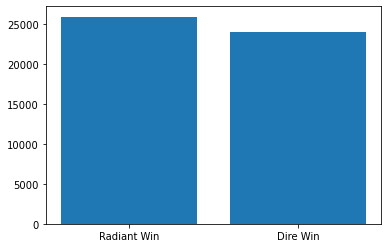

In [ ]:
radiant_win = match[match['radiant_win'] == True].shape[0]
dire_win = match[match['radiant_win'] == False].shape[0]
plt.bar(['Radiant Win', 'Dire Win'], [radiant_win, dire_win])

([<matplotlib.patches.Wedge at 0x7fcb57abe450>,
 [Text(-1.0980697305001865, -0.06513729315259971, 'Radiant Win'),
  Text(1.0980697365987753, 0.06513719034389145, 'Dire Win')],
 [Text(-0.5989471257273744, -0.035529432628690745, '51.9%'),
  Text(0.5989471290538774, 0.035529376551213514, '48.1%')])

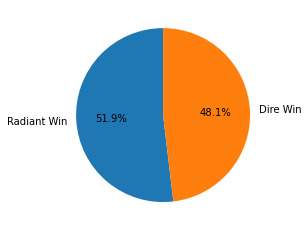

In [ ]:
plt.pie([radiant_win, dire_win], labels=['Radiant Win', 'Dire Win'], autopct='%1.1f%%', startangle=90)

<AxesSubplot:title={'center':'Sorted Frequency of Heroes'}>

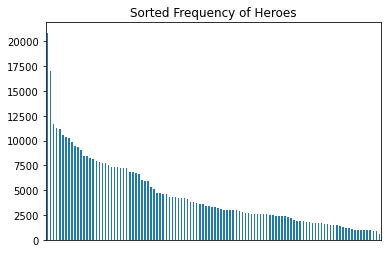

In [ ]:
hero_frequency = Dota['hero_id'].value_counts().sort_values(ascending = False)
hero_frequency.plot(kind = 'bar', xticks = [], title = 'Sorted Frequency of Heroes')

In [ ]:
# Top 10 frequent heroes
top_hero_frequency = hero_frequency[:10].to_list()
for i in range(10):
    name = hero_names[hero_names['hero_id'] == hero_frequency.index[i]]['localized_name']
    print(name.to_list()[0], top_hero_frequency[i])

Windranger 20881
Shadow Fiend 17007
Invoker 11676
Earthshaker 11323
Slardar 11181
Queen of Pain 10590
Juggernaut 10394
Tusk 10306
Alchemist 9823
Pudge 9447


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'The Probability Distribution of gold_spent')

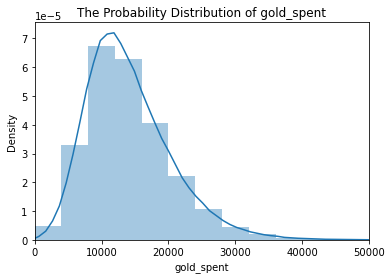

In [ ]:
# Gaussian
sns.distplot(Dota['gold_spent'], kde = True, )
plt.xlim(0, 50000)
plt.title('The Probability Distribution of gold_spent')

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'The Probability Distribution of kills')

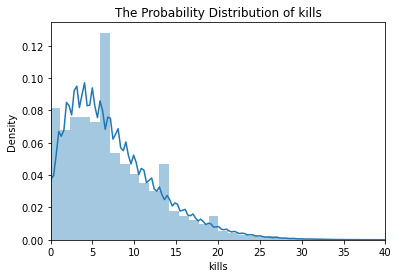

In [ ]:
# Weibull
sns.distplot(Dota['kills'], kde = True)
plt.xlim(0, 40)
plt.title('The Probability Distribution of kills')

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'The Probability Distribution of assists')

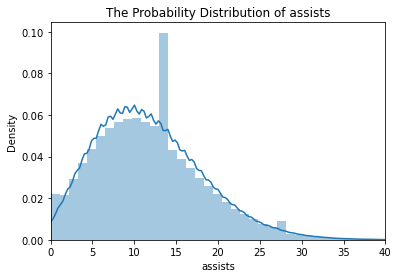

In [ ]:
# Weibull
sns.distplot(Dota['assists'], kde = True)
plt.xlim(0, 40)
plt.title('The Probability Distribution of assists')

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'The Probability Distribution of hero_healing')

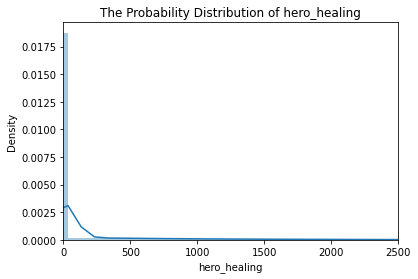

In [ ]:
# Exponential
sns.distplot(Dota['hero_healing'], bins = 500, kde = True, )
plt.xlim(0, 2500)
plt.title('The Probability Distribution of hero_healing')

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'The Probability Distribution of xp_roshan')

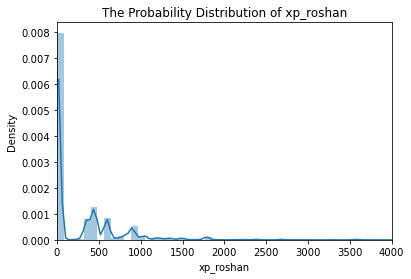

In [ ]:
sns.distplot(Dota['xp_roshan'], bins = 100, kde = True)
plt.xlim(0, 4000)
plt.title('The Probability Distribution of xp_roshan')

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'The Probability Distribution of gold_killing_creeps')

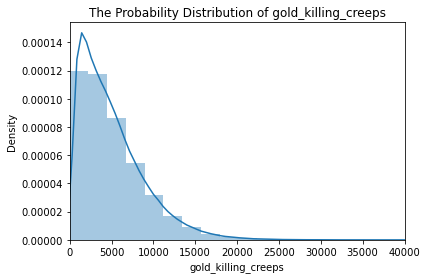

In [ ]:
# Weibull
sns.distplot(Dota['gold_killing_creeps'], kde = True)
plt.xlim(0, 40000)
plt.title('The Probability Distribution of gold_killing_creeps')

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'The Probability Distribution of gold_per_min')

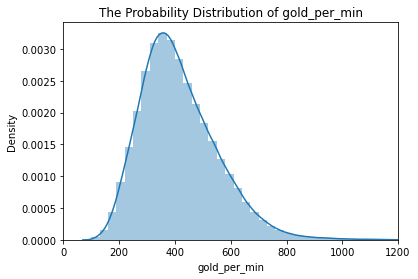

In [ ]:
# Gaussian
sns.distplot(Dota['gold_per_min'], kde = True)
plt.xlim(0, 1200)
plt.title('The Probability Distribution of gold_per_min')

In [ ]:
# Calculate the pearson's correlation coefficient between gold_per_min and kills
Dota[['gold_per_min', 'kills']].corr(method = 'pearson')

,gold_per_min,kills
gold_per_min,1.000000,0.659177
kills,0.659177,1.000000


## 3. Probabilistic Analysis of the data using concepts from ECE 313 (e.g., Probability, Conditional Probability, Total Probability) ##

3.a. Perform a 2-sample KS test to compare the following two distributions: distribution of gold_per_min for radiant team and distribution of gold_per_min for dire team. (Hint: When player_slot == (0,1,2,3,4), it is radiant team. When player_slot == (128,129, 130, 131, 132), then it is a dire team.) What are your null and alternative hypothesis?

3.b. Calculate CPT for P(Raidant_win) and P(dire_win)?

3.c. For each hero, compute posterior probabilities: P(radiant_win | hero_name) and P(dire_win | hero_name)

3.d. For each game_mode, compute posterior probabilities: P(radiant_win | game_mode) and P(dire_win | game_mode)



In [ ]:
# 2-sample KS test
from scipy.stats import ks_2samp

statistic, pvalue = ks_2samp(Dota[Dota['player_slot'].isin([0, 1, 2, 3, 4])]['gold_per_min'], Dota[Dota['player_slot'].isin([128, 129, 130, 131, 132])]['gold_per_min'])
print('The p-value is: {}'.format(pvalue))

The p-value is: 1.7950928246352534e-54


The p-value is less than $\alpha$, so we fail to reject the null hypothesis. The two distributions are likely the same. 

In [ ]:
# Compute posterior probabilities for each hero
all_hero_id = np.sort(Dota['hero_id'].unique())
posterior_hero = {}
for i in all_hero_id:
    total = Dota[Dota['hero_id'] == i].shape[0]
    num_radiant_win = Dota[(Dota['hero_id'] == i) & (Dota['radiant_win'] == True)].shape[0]
    posterior_hero[i] = num_radiant_win / total

posterior_hero[1]

0.5213920817369093

In [ ]:
# Compute posterior probabilities for each game mode
all_game_mode = np.sort(Dota['game_mode'].unique())
posterior_game_mode = {}
for i in all_game_mode:
    total = Dota[Dota['game_mode'] == i].shape[0]
    num_radiant_win = Dota[(Dota['game_mode'] == i) & (Dota['radiant_win'] == True)].shape[0]
    posterior_game_mode[i] = num_radiant_win / total

print(posterior_game_mode)

{2: 0.5082706766917293, 22: 0.5191580210535833}


## 4. Feature Engineering

We have already made a dota.csv file. Our training data will consist tailored features, suited for the ML tasks, subsequently. First, we will encode whether or not (1 or 0) a type of hero is present for that team and compute the sum of the combined item counts for every team. 

https://realpython.com/pandas-groupby/ 

We will also compute the total of the rest of the features for radiant and dire team. 




In [ ]:
Dota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499963 entries, 0 to 499962
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 499963 non-null  int64  
 1   match_id                   499963 non-null  int64  
 2   start_time                 499963 non-null  int64  
 3   duration                   499963 non-null  int64  
 4   tower_status_radiant       499963 non-null  int64  
 5   tower_status_dire          499963 non-null  int64  
 6   barracks_status_dire       499963 non-null  int64  
 7   barracks_status_radiant    499963 non-null  int64  
 8   first_blood_time           499963 non-null  int64  
 9   game_mode                  499963 non-null  int64  
 10  radiant_win                499963 non-null  bool   
 11  hero_id                    499963 non-null  int64  
 12  localized_name             499963 non-null  object 
 13  account_id                 49

In [ ]:
Dota['team'] = np.nan
mask1 = (Dota['player_slot'] == 0.0) | (Dota['player_slot'] == 1.0)  | (Dota['player_slot'] == 2.0)  | (Dota['player_slot'] == 3.0)  | (Dota['player_slot'] == 4.0) 
mask2 = (Dota['player_slot'] == 128.0) | (Dota['player_slot'] == 129.0)  | (Dota['player_slot'] == 130.0)  | (Dota['player_slot'] == 131.0)  | (Dota['player_slot'] == 132.0)
Dota.loc[mask1, 'team'] = 'radiant'
Dota.loc[mask2, 'team'] = 'dire'
Dota[Dota['match_id'] == 0]

,Unnamed: 0,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,...,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,team
0,0,0,1446750112,2375,1982,4,3,63,1,22,...,-3286.0,-39.0,0.0,0.0,320.0,2127.0,1089.0,0.0,0.0,dire
1,1,0,1446750112,2375,1982,4,3,63,1,22,...,-2156.0,0.0,0.0,938.0,4714.0,4104.0,10432.0,400.0,0.0,radiant
2,2,0,1446750112,2375,1982,4,3,63,1,22,...,-3682.0,0.0,0.0,242.0,695.0,4350.0,8797.0,0.0,0.0,dire
3,3,0,1446750112,2375,1982,4,3,63,1,22,...,-1137.0,0.0,0.0,1650.0,3299.0,6676.0,4317.0,937.0,0.0,radiant
4,4,0,1446750112,2375,1982,4,3,63,1,22,...,-1437.0,-1056.0,0.0,4194.0,3217.0,7467.0,9220.0,400.0,0.0,radiant
5,5,0,1446750112,2375,1982,4,3,63,1,22,...,-4039.0,-1063.0,0.0,637.0,320.0,2685.0,7011.0,0.0,0.0,dire
6,6,0,1446750112,2375,1982,4,3,63,1,22,...,-1436.0,-1015.0,0.0,0.0,3142.0,2418.0,3697.0,400.0,0.0,radiant
7,7,0,1446750112,2375,1982,4,3,63,1,22,...,-957.0,0.0,0.0,212.0,3120.0,5145.0,1087.0,400.0,0.0,radiant
8,8,0,1446750112,2375,1982,4,3,63,1,22,...,-3287.0,0.0,0.0,262.0,320.0,3396.0,4356.0,0.0,0.0,dire
9,9,0,1446750112,2375,1982,4,3,63,1,22,...,-2394.0,-2240.0,0.0,200.0,320.0,5281.0,6193.0,0.0,0.0,dire


In [ ]:
hero_lookup = dict(zip(hero_names['hero_id'], hero_names['localized_name']))
hero_lookup[0] = 'Unknown'
players['hero'] = players['hero_id'].apply(lambda _id: hero_lookup[_id])

item_lookup = dict(zip(item_ids['item_id'], item_ids['item_name']))
item_lookup[0] = 'Unknown'

def find_item(_id):
    return item_lookup.get(_id, 'u_' + str(_id))

players['item_0'] = players['item_0'].apply(find_item)
players['item_1'] = players['item_1'].apply(find_item)
players['item_2'] = players['item_2'].apply(find_item)
players['item_3'] = players['item_3'].apply(find_item)
players['item_4'] = players['item_4'].apply(find_item)
players['item_5'] = players['item_5'].apply(find_item)

player_heroes = pd.get_dummies(players['hero'])

item0 = pd.get_dummies(players['item_0'].fillna(0))
item1 = pd.get_dummies(players['item_1'].fillna(0))
item2 = pd.get_dummies(players['item_2'].fillna(0))
item3 = pd.get_dummies(players['item_3'].fillna(0))
item4 = pd.get_dummies(players['item_4'].fillna(0))
item5 = pd.get_dummies(players['item_5'].fillna(0))


player_items = item0 \
    .add(item1, fill_value=0) \
    .add(item2, fill_value=0) \
    .add(item3, fill_value=0) \
    .add(item4, fill_value=0) \
    .add(item5, fill_value=0)

radiant_cols = list(map(lambda s: 'radiant_' + s, player_heroes.columns.values))
dire_cols = list(map(lambda s: 'dire_' + s, player_heroes.columns.values))

radiant_items_cols = list(map(lambda s: 'radiant_' + str(s), player_items.columns.values))
dire_items_cols = list(map(lambda s: 'dire_' + str(s), player_items.columns.values))

In [ ]:
from os.path import isfile

X = None

if isfile('mapped_match_hero_item.csv'):
  X = pd.read_csv('mapped_match_hero_item.csv')
else:

  radiant_heroes = []
  dire_heroes = []
  radiant_items = []
  dire_items = []
  match_ids = []
  for _id, _index in players.groupby('match_id').groups.items():
    radiant_heroes.append(player_heroes.iloc[_index][:5].sum().values)
    dire_heroes.append(player_heroes.iloc[_index][5:].sum().values)
    radiant_items.append(player_items.iloc[_index][:5].sum().values)
    dire_items.append(player_items.iloc[_index][5:].sum().values)
    match_ids.append(_id) #Group label

  radiant_heroes = pd.DataFrame(radiant_heroes, columns=radiant_cols)
  dire_heroes = pd.DataFrame(dire_heroes, columns=dire_cols)
  radiant_items = pd.DataFrame(radiant_items, columns=radiant_items_cols)
  dire_items = pd.DataFrame(dire_items, columns=dire_items_cols)
  match_ids = pd.DataFrame(match_ids, columns = ["match_id"])
  X = pd.concat([radiant_heroes, radiant_items, dire_heroes, dire_items, match_ids], axis=1)
  X.to_csv('mapped_match_hero_item.csv', index=False)

In [ ]:
X.head()

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,dire_veil_of_discord,dire_vitality_booster,dire_vladmir,dire_void_stone,dire_ward_dispenser,dire_ward_observer,dire_ward_sentry,dire_wraith_band,dire_yasha,match_id
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
4,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4


In [ ]:
Dota['team'] = np.nan
mask1 = (Dota['player_slot'] == 0.0) | (Dota['player_slot'] == 1.0)  | (Dota['player_slot'] == 2.0)  | (Dota['player_slot'] == 3.0)  | (Dota['player_slot'] == 4.0) 
mask2 = (Dota['player_slot'] == 128.0) | (Dota['player_slot'] == 129.0)  | (Dota['player_slot'] == 130.0)  | (Dota['player_slot'] == 131.0)  | (Dota['player_slot'] == 132.0)
Dota.loc[mask1, 'team'] = 'radiant'
Dota.loc[mask2, 'team'] = 'dire'
Dota[Dota['match_id'] == 0]

gold = Dota.groupby(['match_id','team'])['gold'].sum().unstack() #dire, radiant
gold_spent = Dota.groupby(['match_id','team'])['gold_spent'].sum().unstack() #dire, radiant
gold_per_min = Dota.groupby(['match_id','team'])['gold_per_min'].sum().unstack() #dire, radiant
xp_per_min = Dota.groupby(['match_id','team'])['xp_per_min'].sum().unstack() #dire, radiant
kills = Dota.groupby(['match_id','team'])['kills'].sum().unstack() #dire, radiant
deaths = Dota.groupby(['match_id','team'])['deaths'].sum().unstack() #dire, radiant
assists = Dota.groupby(['match_id','team'])['assists'].sum().unstack() #dire, radiant
denies = Dota.groupby(['match_id','team'])['denies'].sum().unstack() #dire, radiant
last_hits = Dota.groupby(['match_id','team'])['last_hits'].sum().unstack() #dire, radiant
#stuns = Dota.groupby(['match_id','team'])['stuns'].sum().unstack() #dire, radiant
hero_damage = Dota.groupby(['match_id','team'])['hero_damage'].sum().unstack() #dire, radiant
hero_healing = Dota.groupby(['match_id','team'])['hero_healing'].sum().unstack() #dire, radiant
tower_damage = Dota.groupby(['match_id','team'])['tower_damage'].sum().unstack() #dire, radiant
level = Dota.groupby(['match_id','team'])['level'].sum().unstack() #dire, radiant
#leaver_status = Dota.groupby(['match_id','leaver_status'])['gold'].sum().unstack() #dire, radiant
xp_hero = Dota.groupby(['match_id','team'])['xp_hero'].sum().unstack() #dire, radiant
xp_creep = Dota.groupby(['match_id','team'])['xp_creep'].sum().unstack() #dire, radiant
xp_roshan = Dota.groupby(['match_id','team'])['xp_roshan'].sum().unstack() #dire, radiant
xp_other = Dota.groupby(['match_id','team'])['xp_other'].sum().unstack() #dire, radiant
gold_other = Dota.groupby(['match_id','team'])['gold_other'].sum().unstack() #dire, radiant
gold_death = Dota.groupby(['match_id','team'])['gold_death'].sum().unstack() #dire, radiant
gold_buyback = Dota.groupby(['match_id','team'])['gold_buyback'].sum().unstack() #dire, radiant
gold_abandon = Dota.groupby(['match_id','team'])['gold_abandon'].sum().unstack() #dire, radiant
gold_sell = Dota.groupby(['match_id','team'])['gold_sell'].sum().unstack() #dire, radiant
gold_destroying_structure = Dota.groupby(['match_id','team'])['gold_destroying_structure'].sum().unstack() #dire, radiant
gold_killing_heros = Dota.groupby(['match_id','team'])['gold_killing_heros'].sum().unstack() #dire, radiant
gold_killing_creeps = Dota.groupby(['match_id','team'])['gold_killing_creeps'].sum().unstack() #dire, radiant
gold_killing_roshan = Dota.groupby(['match_id','team'])['gold_killing_roshan'].sum().unstack() #dire, radiant
gold_killing_couriers = Dota.groupby(['match_id','team'])['gold_killing_couriers'].sum().unstack() #dire, radiant


gold.columns = ['dire_gold', 'radiant_gold']
gold['match_id'] = gold.index
gold_spent.columns = ['dire_gold_spent', 'radiant_gold_spent']
gold_spent['match_id'] = gold_spent.index
gold_per_min.columns = ['dire_gold_per_min', 'radiant_gold_per_min']
gold_per_min['match_id'] = gold_per_min.index
xp_per_min.columns = ['dire_xp_per_min', 'radiant_xp_per_min']
xp_per_min['match_id'] = xp_per_min.index
kills.columns = ['dire_kills', 'radiant_kills'] 
kills['match_id'] = kills.index
deaths.columns = ['dire_deaths', 'radiant_deaths'] 
deaths['match_id'] = deaths.index
assists.columns = ['dire_assists', 'radiant_assists'] 
assists['match_id'] = assists.index
denies.columns = ['dire_denies', 'radiant_denies'] 
denies['match_id'] = denies.index
last_hits.columns = ['dire_last_hits', 'radiant_last_hits'] 
last_hits['match_id'] = last_hits.index

hero_damage.columns = ['dire_hero_damage', 'radiant_hero_damage'] 
hero_damage['match_id'] = hero_damage.index
hero_healing.columns = ['dire_hero_healing', 'radiant_hero_healing'] 
hero_healing['match_id'] = hero_healing.index
tower_damage.columns = ['dire_tower_damage', 'radiant_tower_damage'] 
tower_damage['match_id'] = tower_damage.index
level.columns = ['dire_level', 'radiant_level'] 
level['match_id'] = level.index

xp_hero.columns = ['dire_xp_hero', 'radiant_xp_hero'] 
xp_hero['match_id'] = xp_hero.index
xp_creep.columns = ['dire_xp_creep', 'radiant_xp_creep'] 
xp_creep['match_id'] = xp_creep.index
xp_roshan.columns = ['dire_xp_roshan', 'radiant_xp_roshan'] 
xp_roshan['match_id'] = xp_roshan.index
xp_other.columns = ['dire_xp_other', 'radiant_xp_other'] 
xp_other['match_id'] = xp_other.index
gold_other.columns = ['dire_gold_other', 'radiant_gold_other'] 
gold_other['match_id'] = gold_other.index
gold_death.columns = ['dire_gold_death', 'radiant_gold_death'] 
gold_death['match_id'] = gold_death.index
gold_buyback.columns = ['dire_gold_buyback', 'radiant_gold_buyback'] 
gold_buyback['match_id'] = gold_buyback.index
gold_abandon.columns = ['dire_gold_abandon', 'radiant_gold_abandon'] 
gold_abandon['match_id'] = gold_abandon.index
gold_sell.columns = ['dire_gold_sell', 'radiant_gold_sell'] 
gold_sell['match_id'] = gold_sell.index
gold_destroying_structure.columns = ['dire_gold_destroying_structure', 'radiant_gold_destroying_structure'] 
gold_destroying_structure['match_id'] = gold_destroying_structure.index
gold_killing_heros.columns = ['dire_gold_killing_heros', 'radiant_gold_killing_heros'] 
gold_killing_heros['match_id'] = gold_killing_heros.index
gold_killing_creeps.columns = ['dire_gold_killing_creeps', 'radiant_gold_killing_creeps'] 
gold_killing_creeps['match_id'] = gold_killing_creeps.index
gold_killing_roshan.columns = ['dire_gold_killing_roshan', 'radiant_gold_killing_roshan'] 
gold_killing_roshan['match_id'] = gold_killing_roshan.index
gold_killing_couriers.columns = ['dire_gold_killing_couriers', 'radiant_gold_killing_couriers'] 
gold_killing_couriers['match_id'] = gold_killing_couriers.index

In [ ]:
gold = pd.DataFrame(gold.to_numpy(), columns =gold.columns)

gold_spent = pd.DataFrame(gold_spent.to_numpy(), columns =gold_spent.columns)

gold_per_min = pd.DataFrame(gold_per_min.to_numpy(), columns =gold_per_min.columns)

xp_per_min = pd.DataFrame(xp_per_min.to_numpy(), columns =xp_per_min.columns)

kills = pd.DataFrame(kills.to_numpy(), columns =kills.columns)

deaths = pd.DataFrame(deaths.to_numpy(), columns =deaths.columns)

assists = pd.DataFrame(assists.to_numpy(), columns =assists.columns)

denies = pd.DataFrame(denies.to_numpy(), columns =denies.columns)

last_hits = pd.DataFrame(last_hits.to_numpy(), columns =last_hits.columns)

hero_damage = pd.DataFrame(hero_damage.to_numpy(), columns =hero_damage.columns)

hero_healing = pd.DataFrame(hero_healing.to_numpy(), columns =hero_healing.columns)

tower_damage = pd.DataFrame(tower_damage.to_numpy(), columns =tower_damage.columns)

level  = pd.DataFrame(level.to_numpy(), columns =level.columns)

xp_hero = pd.DataFrame(xp_hero.to_numpy(), columns =xp_hero.columns)

xp_creep = pd.DataFrame(xp_creep.to_numpy(), columns =xp_creep.columns)

xp_roshan = pd.DataFrame(xp_roshan.to_numpy(), columns =xp_roshan.columns)

xp_other = pd.DataFrame(xp_other.to_numpy(), columns =xp_other.columns)

gold_other = pd.DataFrame(gold_other.to_numpy(), columns =gold_other.columns)

gold_death = pd.DataFrame(gold_death.to_numpy(), columns =gold_death.columns)

gold_buyback = pd.DataFrame(gold_buyback.to_numpy(), columns =gold_buyback.columns)

gold_abandon = pd.DataFrame(gold_abandon.to_numpy(), columns =gold_abandon.columns)

gold_sell = pd.DataFrame(gold_sell.to_numpy(), columns =gold_sell.columns)

gold_destroying_structure = pd.DataFrame(gold_destroying_structure.to_numpy(), columns =gold_destroying_structure.columns)

gold_killing_heros = pd.DataFrame(gold_killing_heros.to_numpy(), columns =gold_killing_heros.columns)

gold_killing_creeps = pd.DataFrame(gold_killing_creeps.to_numpy(), columns =gold_killing_creeps.columns)

gold_killing_roshan = pd.DataFrame(gold_killing_roshan.to_numpy(), columns =gold_killing_roshan.columns)

gold_killing_couriers = pd.DataFrame(gold_killing_couriers.to_numpy(), columns =gold_killing_couriers.columns)

In [ ]:
from os.path import isfile
from functools import reduce
df_merged = None

if isfile('df_merged.csv'): #Checks if the file with name 'dota.csv' exits
  df_merged = pd.read_csv('df_merged.csv')
else:
  #https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes
  # compile the list of dataframes you want to merge
  data_frames = [X, gold, gold_spent, gold_per_min, xp_per_min, kills, deaths, assists, denies, last_hits, hero_damage, hero_healing, tower_damage, level, xp_hero, xp_creep, xp_roshan, xp_other, gold_other, gold_death, gold_buyback, gold_abandon, gold_sell, gold_destroying_structure, gold_killing_heros, gold_killing_creeps, gold_killing_roshan, gold_killing_couriers]
  # if you want to fill the values that don't exist in the lines of merged dataframe simply fill with required strings as

  df_merged = reduce(lambda  left,right: pd.merge(left, right, left_on="match_id", right_on= "match_id", how='left'), data_frames).fillna(0)
  df_merged.to_csv('df_merged.csv', index=False)

In [ ]:
df_merged.describe()

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,dire_gold_destroying_structure,radiant_gold_destroying_structure,dire_gold_killing_heros,radiant_gold_killing_heros,dire_gold_killing_creeps,radiant_gold_killing_creeps,dire_gold_killing_roshan,radiant_gold_killing_roshan,dire_gold_killing_couriers,radiant_gold_killing_couriers
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.033720,0.099260,0.067620,0.092740,0.045820,0.02560,0.009960,0.012980,0.029980,0.067040,...,11499.083240,12024.802300,24648.060520,24711.685520,25495.604100,25514.13586,1166.473980,790.249640,198.424400,183.705800
std,0.180509,0.299014,0.251095,0.290071,0.209097,0.15794,0.099303,0.113189,0.170534,0.250094,...,8699.739518,8296.032832,9797.319571,9517.248966,10225.532993,9940.37095,1245.592684,1002.749772,399.620567,384.395665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,120.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,2621.000000,3253.750000,18037.750000,18320.000000,18235.500000,18470.75000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,11481.500000,13246.500000,24009.000000,23841.000000,24297.000000,24170.00000,1210.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,21061.250000,20869.000000,30501.000000,30235.000000,31396.750000,31078.25000,2337.000000,1309.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,24048.000000,23790.000000,105987.000000,155616.000000,259319.000000,260094.00000,16552.000000,6652.000000,6335.000000,8125.000000


In [ ]:
df_merged['match_id']

0            0
1            1
2            2
3            3
4            4
         ...  
49995    49995
49996    49996
49997    49997
49998    49998
49999    49999
Name: match_id, Length: 50000, dtype: int64

In [ ]:
df_merged.to_csv('df_merged.csv', index=False)

In [ ]:
df_merged.drop(columns = ['match_id'], inplace=True)
labels = match['radiant_win']

## 5. Exploring the features with data at the end of a game
### a. Naive Bayes Model

https://www.geeksforgeeks.org/decision-tree-implementation-python/



In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve

In [ ]:
# Function to make predictions 
def prediction(X_test, clf_object): 
  
    # Predicton on test
    y_pred = clf_object.predict(X_test) 
    #print("Predicted values:") 
    #print(y_pred) 
    return y_pred

# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: \n", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred))

In [ ]:
def print_confusion_matrix(y_test, yhat):
  cm_val = confusion_matrix(y_test, yhat)
  plt.figure(figsize=(10,7))
  sns.heatmap(cm_val, annot=True, fmt='g')
  plt.xlabel('classes - predicted')
  plt.ylabel('classes - truth')
  plt.show()

In [ ]:
# Function to perform training with GaussianNB. 
def train_using_gaussianNB(X_train, X_test, y_train): 
  
    # Creating the classifier object 
    clf_gnb = GaussianNB() 
  
    # Performing training 
    clf_gnb.fit(X_train, y_train) 
    return clf_gnb
# Function to perform training with MultinomialNB. 
def train_using_multinomialNB(X_train, X_test, y_train): 
  
    # Creating the classifier object 
    clf_mnb = MultinomialNB() 
  
    # Performing training 
    clf_mnb.fit(X_train, y_train) 
    return clf_mnb

#Function to perform training with BernouilliNB
def train_using_BernouilliNB(X_train, X_test, y_train): 
  
    # Creating the classifier object 
    clf_bnb = BernoulliNB() 
  
    # Performing training 
    clf_bnb.fit(X_train, y_train) 
    return clf_bnb

In [ ]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html
X = df_merged.values
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
gnb = train_using_gaussianNB(X_train, X_test, y_train)
bnb = train_using_BernouilliNB(X_train, X_test, y_train)

yhat_gnb = prediction(X_test, gnb)
yhat_bnb = prediction(X_test, bnb)

In [ ]:
cal_accuracy(y_test, yhat_gnb)

Confusion Matrix: 
 [[ 78455 138665]
 [ 40559 184277]]
Accuracy :  59.44754681461502
Report :                precision    recall  f1-score   support

       False       0.66      0.36      0.47    217120
        True       0.57      0.82      0.67    224836

    accuracy                           0.59    441956
   macro avg       0.61      0.59      0.57    441956
weighted avg       0.61      0.59      0.57    441956



In [ ]:
cal_accuracy(y_test, yhat_bnb)

Confusion Matrix: 
 [[     0 217120]
 [     0 224836]]
Accuracy :  50.8729375774964


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Report :                precision    recall  f1-score   support

       False       0.00      0.00      0.00    217120
        True       0.51      1.00      0.67    224836

    accuracy                           0.51    441956
   macro avg       0.25      0.50      0.34    441956
weighted avg       0.26      0.51      0.34    441956



/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


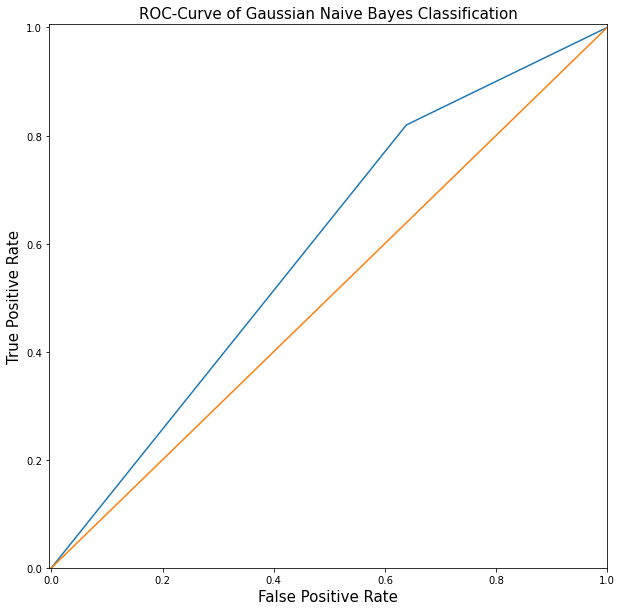

In [ ]:
fpr,tpr,threshold=roc_curve(y_test,yhat_gnb)
line=[0,1]
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC-Curve of Gaussian Naive Bayes Classification',fontsize=15)
plt.axis([-0.004,1,0,1.006])
plt.show()

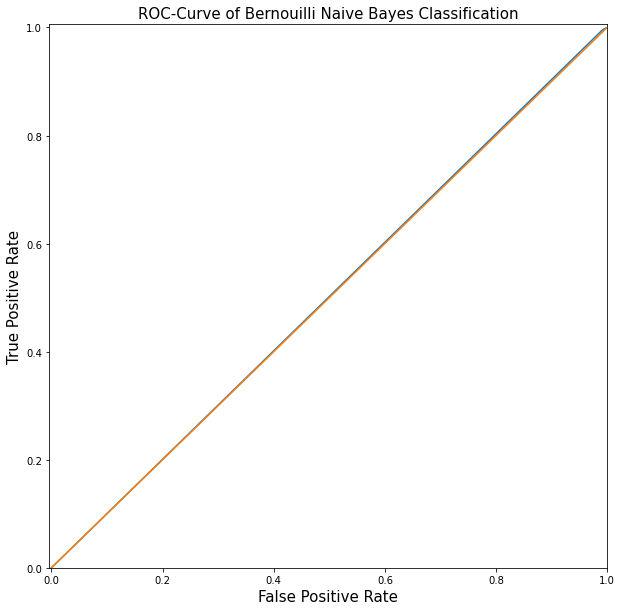

In [ ]:
fpr,tpr,threshold=roc_curve(y_test,yhat_bnb)
line=[0,1]
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC-Curve of Bernouilli Naive Bayes Classification',fontsize=15)
plt.axis([-0.004,1,0,1.006])
plt.show()

### b. Decision Tree



In [ ]:
import io
from scipy import misc
import imageio
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pydotplus
# Then, we define a function that can show us our decision tree model:

def show_tree(decisionTree, file_path):
    dotfile = io.StringIO()
    export_graphviz(decisionTree, 
                    max_depth=4,
                    label=None,
                    impurity=False,
                    filled=True,
                    rounded=True,
                    proportion=False,
                    rotate=True,
                    out_file=dotfile, 
                    class_names= ['Dire Win', 'Radiant Win'], 
                    feature_names=df_merged.columns)
    pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png(file_path)
    i = imageio.imread(file_path) #https://stackoverflow.com/questions/15345790/scipy-misc-module-has-no-attribute-imread
    plt.figure(figsize=(100,100))
    plt.imshow(i, interpolation='nearest')

# Also, we define a wrapper that cross-validates, fits and displays our model for easy reuse:
def build_decision_tree(X, y, depth=None):
    dt = DecisionTreeClassifier(random_state=42, max_depth=depth)
    print('CV score:', cross_val_score(estimator=dt, X=X, y=y).mean())
    dt.fit(X, y)
    show_tree(dt, 'tree.png')
    return dt

dt = build_decision_tree(X=X_train, y=y_train, depth=10)


KeyboardInterrupt: 

In [ ]:
#Top 20 important features
def get_tree_stats(dt):
    feature_importances = dict(zip(df_merged.columns, dt.feature_importances_))
    feature_importances = pd.Series(feature_importances).sort_values(ascending=False)
    return feature_importances.iloc[feature_importances.to_numpy().nonzero()] #https://pandas.pydata.org/pandas-docs/version/0.25.3/reference/api/pandas.Series.nonzero.html

In [ ]:
get_tree_stats(dt).head(20)

In [ ]:
yhat_dt = dt.predict(X_test)
cal_accuracy(y_test, yhat_dt)

Confusion Matrix: 
 [[4706   52]
 [  55 5187]]
Accuracy :  98.92999999999999
Report :                precision    recall  f1-score   support

       False       0.99      0.99      0.99      4758
        True       0.99      0.99      0.99      5242

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### c. RandomForest

https://github.com/srp98/Classification-of-Data-with-Random-Forests-and-Decision-Trees/blob/master/RandomForests.py


In [ ]:
X = df_merged.values
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
class_names = ['Dire Win', 'Radiant Win'] 
feature_names = df_merged.columns

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.externals.six import StringIO
import pydotplus
from sklearn import tree

def train_using_RF(X_train, X_test, y_train, n_estimators): 
  
    # Creating the classifier object 
    clf_rf = RandomForestClassifier(n_estimators=10, criterion='entropy')
  
    # Performing training 
    clf_rf.fit(X_train, y_train) 
    return clf_rf

In [ ]:
rf = train_using_RF(X_train, X_test, y_train, 200)
yhat_rf = rf.predict(X_test)

In [ ]:
cal_accuracy(y_test, yhat_rf)

Confusion Matrix: 
 [[177963  39157]
 [ 54432 170404]]
Accuracy :  78.8239100724959
Report :                precision    recall  f1-score   support

       False       0.77      0.82      0.79    217120
        True       0.81      0.76      0.78    224836

    accuracy                           0.79    441956
   macro avg       0.79      0.79      0.79    441956
weighted avg       0.79      0.79      0.79    441956



In [ ]:
# Visualize the data
dot_data = io.StringIO()
filename = 'forests.png'

# Replace the argument for rf below with the tree number to view that tree
tree.export_graphviz(rf[1], out_file=dot_data,
                     feature_names=feature_names,
                     class_names=class_names,
                     filled=True, rounded=True,
                     special_characters=True, max_depth=1,
                     label=None,
                    impurity=False,
                    proportion=False,
                    rotate=True,
                     leaves_parallel=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Write the output to the file
graph.write_png(filename)
print('File Created')

InvocationException: GraphViz's executables not found

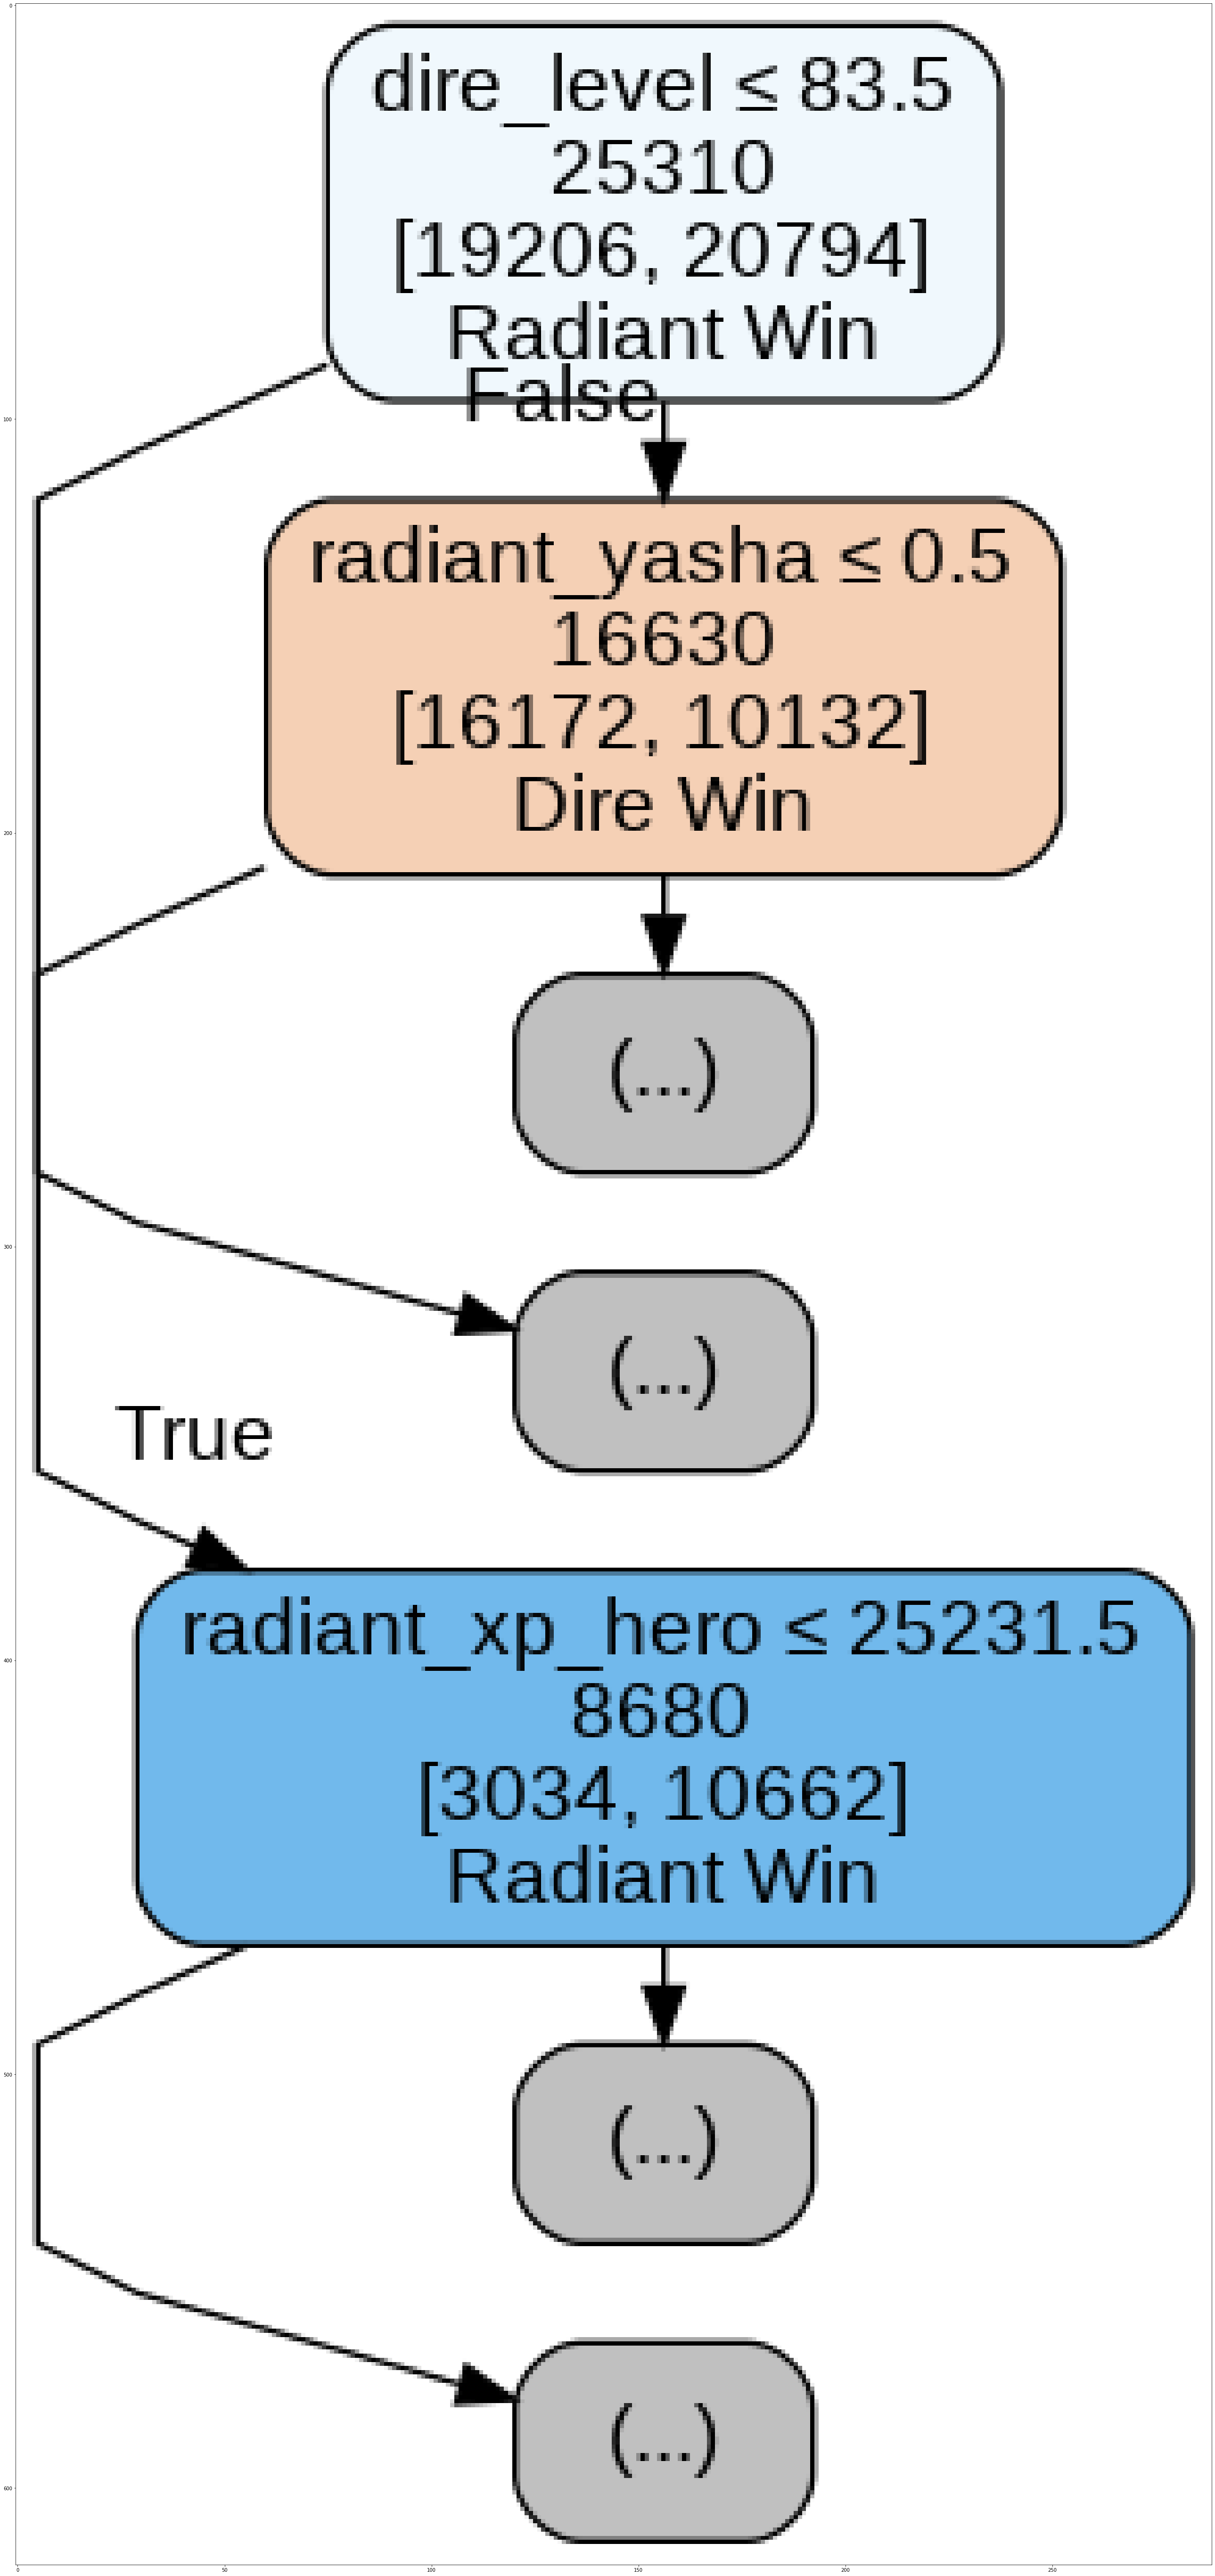

In [ ]:
i = imageio.imread(filename) #https://stackoverflow.com/questions/15345790/scipy-misc-module-has-no-attribute-imread
plt.figure(figsize=(100,100))
plt.imshow(i, interpolation='nearest')
plt.show()

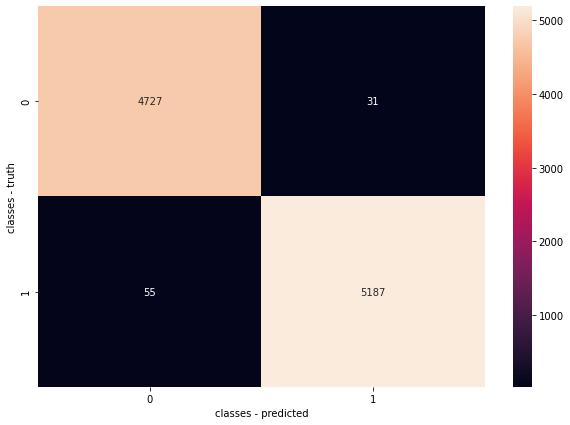

In [ ]:
cm_val = confusion_matrix(y_test, yhat_rf)
plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

In [ ]:
rf.decision_path(X_test)

(<10000x12102 sparse matrix of type '<class 'numpy.longlong'>'
 	with 917557 stored elements in Compressed Sparse Row format>,
 array([    0,  1361,  2712,  3885,  4768,  5719,  6854,  8695,  9752,
        10823, 12102]))

In [ ]:
get_tree_stats(rf).head(40)

gold_t_0      0.042296
gold_t_128    0.041325
gold_t_2      0.040279
gold_t_1      0.039913
gold_t_4      0.039902
gold_t_132    0.039564
gold_t_3      0.039549
gold_t_130    0.039234
gold_t_129    0.039054
gold_t_131    0.038423
xp_t_3        0.035248
xp_t_129      0.035040
xp_t_131      0.034948
xp_t_4        0.034422
xp_t_130      0.034326
xp_t_0        0.034192
xp_t_2        0.034186
xp_t_128      0.033935
xp_t_132      0.033917
xp_t_1        0.033408
lh_t_3        0.025045
lh_t_0        0.024955
lh_t_4        0.024898
lh_t_129      0.024881
lh_t_2        0.024772
lh_t_128      0.024746
lh_t_132      0.024681
lh_t_131      0.024544
lh_t_1        0.024522
lh_t_130      0.024282
times         0.009514
dtype: float64

In [ ]:
feature_importance = sorted(rf.feature_importances_, reverse=True)[:15]

In [ ]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(feature_importance)
tree_indices = np.arange(0, len(feature_importance)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         feature_importance[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(feature_importance)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html#sphx-glr-auto-examples-ensemble-plot-forest-iris-py

### d. Support Vector Machines



In [ ]:
from sklearn.svm import SVC

In [ ]:
def train_using_SVM(X_train, X_test, y_train): 
  
    # Creating the classifier object 
    clf_svm = SVC()
  
    # Performing training 
    clf_svm.fit(X_train, y_train) 
    return clf_svm

In [ ]:
svm = train_using_SVM(X_train, X_test, y_train)
yhat_svm = svm.predict(X_test)

In [ ]:
cal_accuracy(y_test, yhat_svm)

Confusion Matrix: 
 [[4722   36]
 [  26 5216]]
Accuracy :  99.38
Report :                precision    recall  f1-score   support

       False       0.99      0.99      0.99      4758
        True       0.99      1.00      0.99      5242

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



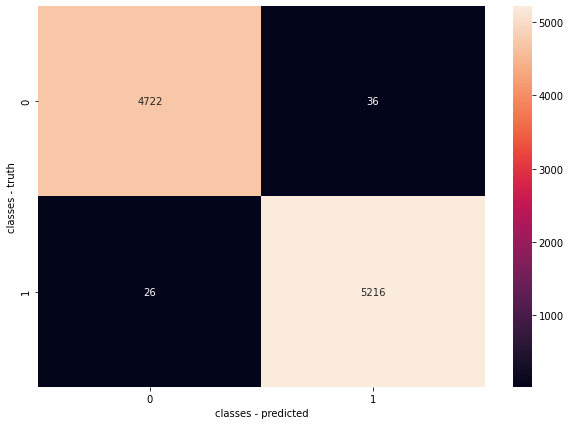

In [ ]:
print_confusion_matrix(y_test, yhat_svm)

It takes a long time to run SVM. Hence, we will be using PCA to reduce the dimensionality of the training dataset.

In [ ]:
df_merged.head()

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,radiant_Brewmaster,radiant_Bristleback,radiant_Broodmother,radiant_Centaur Warrunner,radiant_Chaos Knight,radiant_Chen,radiant_Clinkz,radiant_Clockwerk,radiant_Crystal Maiden,radiant_Dark Seer,radiant_Dazzle,radiant_Death Prophet,radiant_Disruptor,radiant_Doom,radiant_Dragon Knight,radiant_Drow Ranger,radiant_Earth Spirit,radiant_Earthshaker,radiant_Elder Titan,radiant_Ember Spirit,radiant_Enchantress,radiant_Enigma,radiant_Faceless Void,radiant_Gyrocopter,radiant_Huskar,radiant_Invoker,radiant_Io,radiant_Jakiro,radiant_Juggernaut,radiant_Keeper of the Light,...,dire_denies,radiant_denies,dire_last_hits,radiant_last_hits,dire_hero_damage,radiant_hero_damage,dire_hero_healing,radiant_hero_healing,dire_tower_damage,radiant_tower_damage,dire_level,radiant_level,dire_xp_hero,radiant_xp_hero,dire_xp_creep,radiant_xp_creep,dire_xp_roshan,radiant_xp_roshan,dire_xp_other,radiant_xp_other,dire_gold_other,radiant_gold_other,dire_gold_death,radiant_gold_death,dire_gold_buyback,radiant_gold_buyback,dire_gold_abandon,radiant_gold_abandon,dire_gold_sell,radiant_gold_sell,dire_gold_destroying_structure,radiant_gold_destroying_structure,dire_gold_killing_heros,radiant_gold_killing_heros,dire_gold_killing_creeps,radiant_gold_killing_creeps,dire_gold_killing_roshan,radiant_gold_killing_roshan,dire_gold_killing_couriers,radiant_gold_killing_couriers
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38.0,30.0,651.0,713.0,47155.0,85226.0,1056.0,4770.0,2550.0,8853.0,84.0,100.0,32013.0,54260.0,49581.0,50547.0,0.0,3577.0,1206.0,1562.0,5786.0,804.0,-16688.0,-7123.0,-3342.0,-2071.0,0.0,0.0,1341.0,6994.0,1975.0,17492.0,17839.0,25810.0,27446.0,28753.0,0.0,2537.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,16.0,27.0,990.0,755.0,93316.0,58584.0,0.0,0.0,11148.0,2420.0,111.0,92.0,61636.0,35143.0,69377.0,38193.0,1788.0,894.0,1484.0,24611.0,6827.0,1289.0,-12143.0,-19537.0,-1712.0,-1775.0,0.0,0.0,5311.0,4501.0,20759.0,3421.0,30286.0,25493.0,39562.0,30784.0,1310.0,1359.0,0.0,700.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,16.0,10.0,573.0,625.0,61258.0,46043.0,1745.0,16.0,7990.0,1886.0,99.0,80.0,53410.0,21155.0,49894.0,50575.0,1788.0,0.0,2801.0,1297.0,1641.0,1285.0,-6218.0,-16001.0,0.0,0.0,0.0,0.0,3483.0,1000.0,17101.0,3428.0,26161.0,12976.0,22944.0,24607.0,1169.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,29.0,32.0,626.0,580.0,107382.0,86515.0,1046.0,10814.0,9309.0,4604.0,112.0,110.0,84889.0,84107.0,46794.0,43763.0,0.0,3576.0,3761.0,2529.0,1572.0,1231.0,-24295.0,-27444.0,-3883.0,-5563.0,0.0,0.0,4811.0,1221.0,16592.0,8604.0,42083.0,42435.0,23992.0,20766.0,0.0,2584.0,0.0,700.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,21.0,26.0,369.0,668.0,50064.0,57760.0,446.0,2328.0,45.0,13062.0,65.0,85.0,19392.0,31029.0,29549.0,45444.0,0.0,3576.0,446.0,1871.0,356.0,2894.0,-9983.0,-4364.0,-2862.0,0.0,0.0,0.0,517.0,3719.0,0.0,22250.0,17431.0,17215.0,14465.0,28533.0,0.0,2640.0,0.0,0.0


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')
df_merged_pca = pca.fit_transform(df_merged)

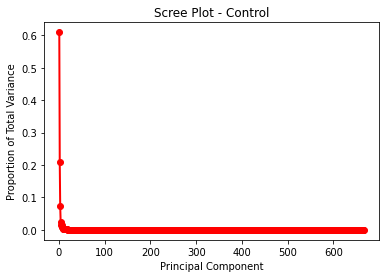

The number of principal components that are needed in order to explain 99.99% of the total variance is 34


In [ ]:
#print("The principal components by decreasing contribution to total variance - control \n", pca.components_)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot - Control')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Total Variance')
plt.show()
num_principcal_components = 0
percent_total_var = 0
i = 0
while(percent_total_var < 0.9999):
    num_principcal_components += 1
    percent_total_var += pca.explained_variance_ratio_[i]
    i+=1

print("The number of principal components that are needed in order to explain 99.99% of the total variance is {}".format(num_principcal_components))


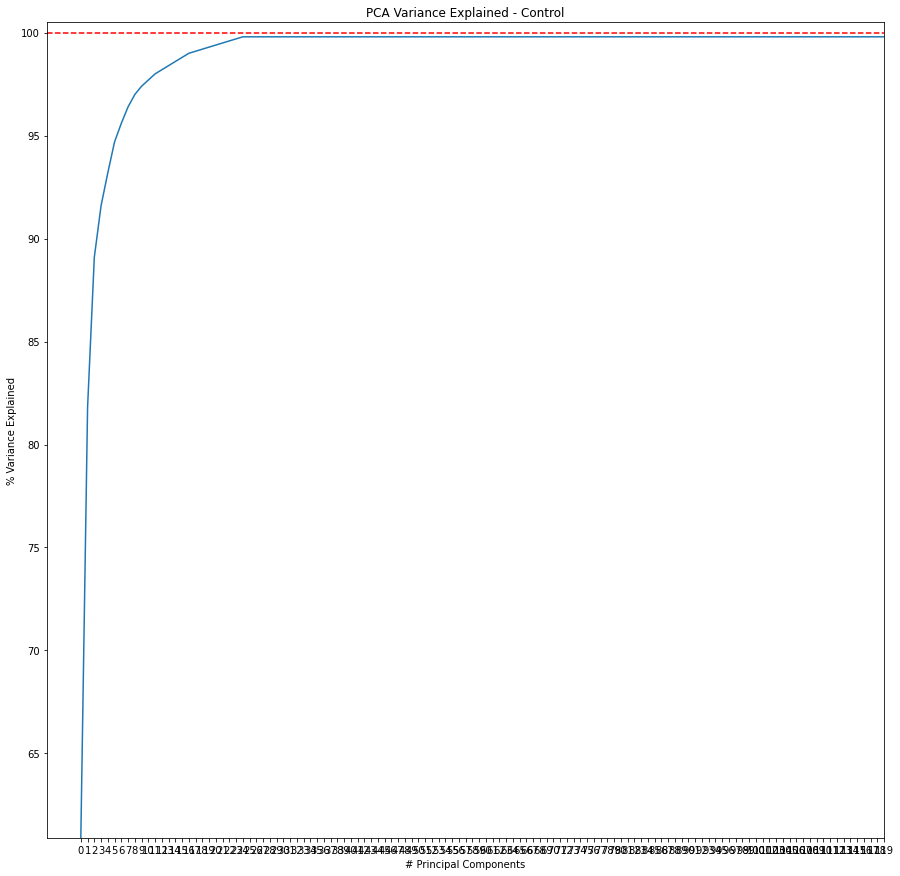

In [ ]:
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, decimals = 3) * 100)
fig, ax = plt.subplots(figsize = (15,15))
plt.ylabel('% Variance Explained')
plt.xlabel('# Principal Components')
plt.title('PCA Variance Explained - Control')
plt.ylim(min(var), 100.5)
plt.xlim(-5,40)
ax.set_xticks(np.arange(120))
ax.set_xticklabels(np.arange(120))
plt.style.context('seaborn-whitegrid')
plt.axhline(y = 99.99, color = 'r', linestyle = '--')
plt.plot(var)
plt.show()

In [ ]:
pca_34 = PCA(n_components=34, svd_solver='full')
df_merged_pca_34 = pca_34.fit_transform(df_merged)

In [ ]:
X = df_merged_pca_34
y = labels.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
svm_34 = train_using_SVM(X_train, X_test, y_train)
yhat_svm_34 = svm_34.predict(X_test)

In [ ]:
cal_accuracy(y_test, yhat_svm_34)

Confusion Matrix: 
 [[4724   34]
 [  32 5210]]
Accuracy :  99.33999999999999
Report :                precision    recall  f1-score   support

       False       0.99      0.99      0.99      4758
        True       0.99      0.99      0.99      5242

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



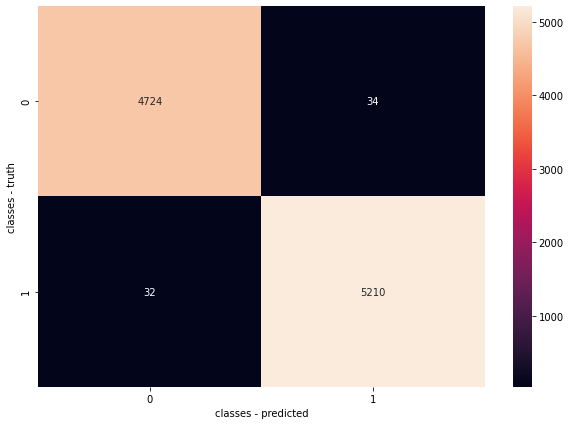

In [ ]:
print_confusion_matrix(y_test, yhat_svm_34)

In [ ]:
#https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
param_grid = {'C': [0.1,1], 'gamma': [0.1,0.01],'kernel': ['rbf']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

In [ ]:
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)

In [ ]:
cal_accuracy(y_test, grid_predictions)

In [ ]:
# https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
# https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
# https://github.com/Madmanius/HyperParameter_tuning_SVM_MNIST/blob/master/HyperParameter_SVM.ipynb
rnd_search_cv = RandomizedSearchCV(SVC(), param_grid, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] kernel=rbf, gamma=0.1, C=0.1 ....................................
[CV] ..................... kernel=rbf, gamma=0.1, C=0.1, total= 2.7min
[CV] kernel=rbf, gamma=0.1, C=0.1 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] ..................... kernel=rbf, gamma=0.1, C=0.1, total= 2.5min
[CV] kernel=rbf, gamma=0.1, C=0.1 ....................................
[CV] ..................... kernel=rbf, gamma=0.1, C=0.1, total= 2.5min
[CV] kernel=rbf, gamma=0.01, C=0.1 ...................................
[CV] .................... kernel=rbf, gamma=0.01, C=0.1, total= 2.5min
[CV] kernel=rbf, gamma=0.01, C=0.1 ...................................
[CV] .................... kernel=rbf, gamma=0.01, C=0.1, total= 2.4min
[CV] kernel=rbf, gamma=0.01, C=0.1 ...................................
[CV] .................... kernel=rbf, gamma=0.01, C=0.1, total= 2.4min
[CV] kernel=rbf, gamma=0.1, C=1 ......................................
[CV] ....................... kernel=rbf, gamma=0.1, C=1, total= 3.0min
[CV] kernel=rbf, gamma=0.1, C=1 ......................................
[CV] ....................... kernel=rbf, gamma=0.1, C=1, total= 3.0min
[CV] kernel=rbf, gamma=0.1, C=1 ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 33.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 1], 'gamma': [0.1, 0.01],
                                        'kernel': ['rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [ ]:
print(rnd_search_cv.best_estimator_)
rnd_predictions = rnd_search_cv.predict(X_test)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
svm_random = SVC(C = 0.1, gamma= 0.1, kernel= 'rbf')
svm_random.fit(X_train, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
yhat_svm_random = svm_random.predict(X_test)

In [ ]:
cal_accuracy(y_test, yhat_svm_random)

Confusion Matrix: 
 [[   0 4758]
 [   0 5242]]
Accuracy :  52.42
Report :                precision    recall  f1-score   support

       False       0.00      0.00      0.00      4758
        True       0.52      1.00      0.69      5242

    accuracy                           0.52     10000
   macro avg       0.26      0.50      0.34     10000
weighted avg       0.27      0.52      0.36     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


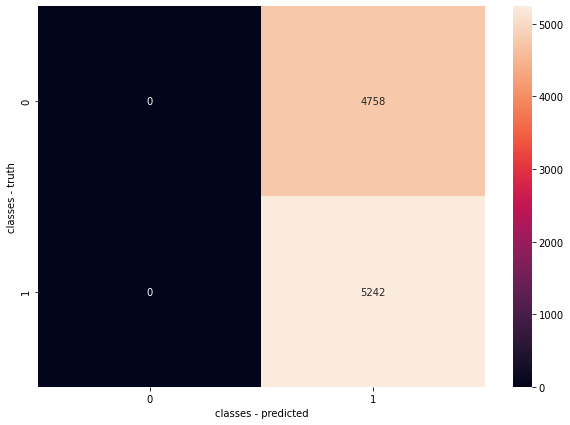

In [ ]:
print_confusion_matrix(y_test, yhat_svm_random)

### e. Deep Neural Networks



In [ ]:
import numpy as np # linear algebra
from numpy import concatenate
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras import models, layers, regularizers, optimizers
import keras.backend as K
import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint


from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
%matplotlib inline

In [ ]:
labels.values

array([ True, False, False, ...,  True,  True, False])

In [ ]:
scaler = MinMaxScaler()
#Normalize the features
scaler.fit(df_merged.values)
X_scaled = scaler.transform(df_merged.values)
y = labels.values
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.1)

dataload = {
        'X_scaled': X_scaled,
        'Y': y,
        'data': df_merged,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }

In [ ]:
def make_model(dataload, activation, n_layers, hidden_units, dropouts, optimizer, loss, metric):
    model = Sequential()
    X_train = dataload['X_train']
    y_train = dataload['y_train']
    X_test = dataload['X_test']
    y_test = dataload['y_test']
    
    for i in range(n_layers):
        if i == 0: #The input layer
            model.add(Dense(hidden_units[i], kernel_initializer='normal',input_dim = X_train.shape[1], activation = activation))
            model.add(Dropout(dropouts[i]))
        else: #hidden layers
            model.add(Dense(hidden_units[i], kernel_initializer='normal',activation= activation))
            model.add(Dropout(dropouts[i]))
    
    #Output layer
    model.add(Dense(1,activation='sigmoid'))

    #Compile the network
    model.compile(loss= loss, optimizer=optimizer, metrics=metric)

    return model

def train_model(dataload, 
                activation, n_layers, hidden_units, dropouts, optimizer, loss, metric,
                epochs, batch_size, validation_split, model_name, call_backs
                ):
    
    X_train = dataload['X_train']
    y_train = dataload['y_train']
    X_test = dataload['X_test']
    y_test = dataload['y_test']
    model = make_model(dataload, activation, n_layers, hidden_units, dropouts, optimizer, loss, metric)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = validation_split, callbacks = call_backs)
    model.save(model_name)
    model_results = {
        'history': history,
        'model': model
    }

    return model_results

def plot_error(model_results):
    history = model_results['history']
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

def visualize_connectivity_graph(model):
    # `rankdir='LR'` is to make the graph horizontal.
    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Epoch 1/100
2532/2532 [==============================] - 9s 3ms/step - loss: 0.1089 - accuracy: 0.9571 - val_loss: 0.0314 - val_accuracy: 0.9891
Epoch 2/100
2532/2532 [==============================] - 7s 3ms/step - loss: 0.0233 - accuracy: 0.9913 - val_loss: 0.0252 - val_accuracy: 0.9931
Epoch 3/100
2532/2532 [==============================] - 7s 3ms/step - loss: 0.0213 - accuracy: 0.9930 - val_loss: 0.0300 - val_accuracy: 0.9891


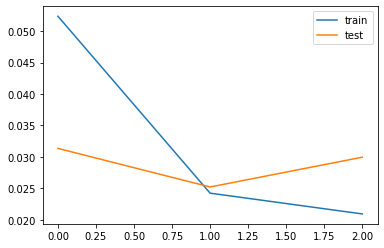

In [ ]:
activation = 'relu'
n_layers = 5
hidden_units = [80,60,50,40,30]
dropouts = [0.1,0.2,0.1,0.2,0.1]
optimizer = 'adam'
loss = "binary_crossentropy"
metric = ["accuracy"]
epochs = 100
batch_size = 16
validation_split = 0.1
model_name = 'model/model-0-00-04-08-2021.h5'
filename = 'result/result-0-00-04-08-2021.csv'
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss'),
             ModelCheckpoint(filepath= model_name, monitor='val_loss', save_best_only=True)]
model_results = train_model(dataload,
                activation, n_layers, hidden_units, dropouts, optimizer, loss, metric,
                epochs, batch_size, validation_split, model_name, callbacks
                )

plot_error(model_results)
#evaluate(dataload, model_results)
#get_error(dataload, model_results)
#get_result(filename, model_results, dataload)

In [ ]:
visualize_connectivity_graph(model_results['model'])

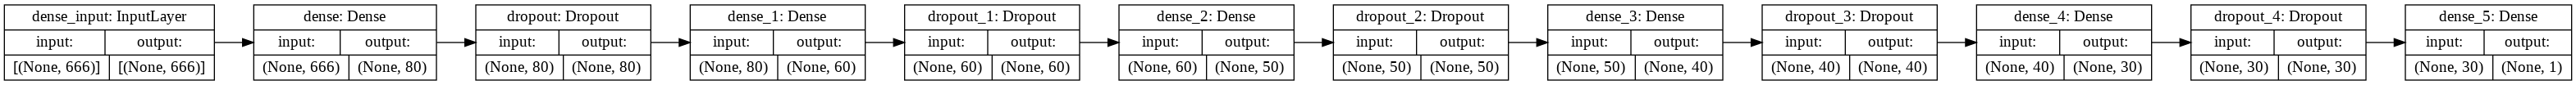

In [ ]:
keras.utils.plot_model(model_results['model'], show_shapes=True, rankdir="LR")

In [ ]:
yhat_nn = model_results['model'].predict(X_test)
yhat_nn

array([[1.5976317e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       ...,
       [2.7021530e-08],
       [1.9056522e-07],
       [1.0000000e+00]], dtype=float32)

In [ ]:
yhat_nn[yhat_nn>0.1] = 1
yhat_nn[yhat_nn<0.1] = 0

In [ ]:
yhat_nn

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [ ]:
cal_accuracy(y_test, yhat_nn)

Confusion Matrix: 
 [[2458   42]
 [   9 2491]]
Accuracy :  98.98
Report :                precision    recall  f1-score   support

       False       1.00      0.98      0.99      2500
        True       0.98      1.00      0.99      2500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



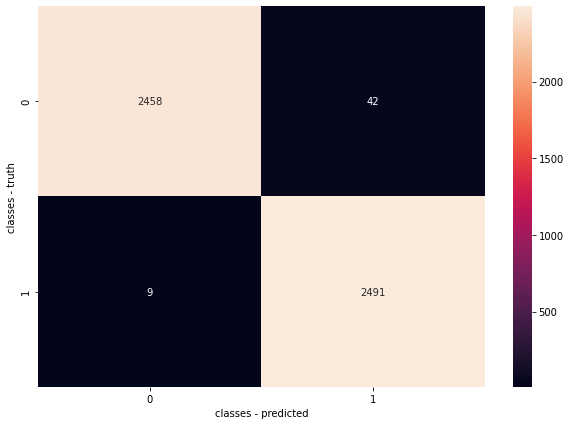

In [ ]:
print_confusion_matrix(y_test, yhat_nn)

Improving the DNN
* We would use StandardScaler, instead of MinMaxScaler.
* We would like to change the dropout probabilities and the number of neurons in each hidden layer.
* We will also play with different optimizers of Keras.


Epoch 1/100
2532/2532 [==============================] - 9s 3ms/step - loss: 0.1103 - accuracy: 0.9452 - val_loss: 0.0290 - val_accuracy: 0.9907
Epoch 2/100
2532/2532 [==============================] - 8s 3ms/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0209 - val_accuracy: 0.9916
Epoch 3/100
2532/2532 [==============================] - 8s 3ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.0191 - val_accuracy: 0.9916
Epoch 4/100
2532/2532 [==============================] - 8s 3ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0332 - val_accuracy: 0.9922


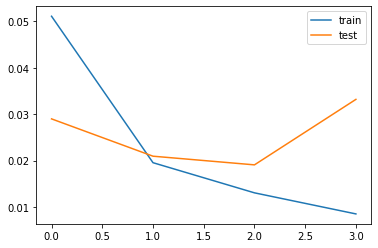

In [ ]:
scaler = StandardScaler()
#Normalize the features
scaler.fit(df_merged.values)
X_scaled = scaler.transform(df_merged.values)
y = labels.values
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.1)

dataload = {
        'X_scaled': X_scaled,
        'Y': y,
        'data': df_merged,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }


activation = 'relu'
n_layers = 5
hidden_units = [80,60,50,40,30]
dropouts = [0.2,0.2,0.3,0.2,0.1]
optimizer = 'adam'
loss = "binary_crossentropy"
metric = ["accuracy"]
epochs = 100
batch_size = 16
validation_split = 0.1
model_name = 'model/model-0-00-05-01-2021.h5'
filename = 'result/result-0-00-05-01-2021.csv'
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss'),
             ModelCheckpoint(filepath= model_name, monitor='val_loss', save_best_only=True)]
model_results = train_model(dataload,
                activation, n_layers, hidden_units, dropouts, optimizer, loss, metric,
                epochs, batch_size, validation_split, model_name, callbacks
                )

plot_error(model_results)
#evaluate(dataload, model_results)
#get_error(dataload, model_results)
#get_result(filename, model_results, dataload)

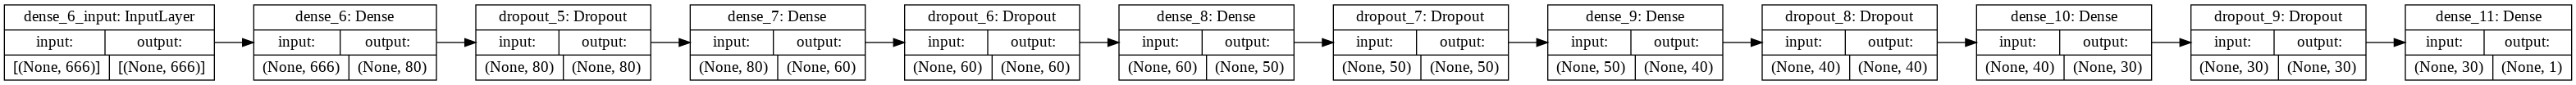

In [ ]:
keras.utils.plot_model(model_results['model'], show_shapes=True, rankdir="LR")

Confusion Matrix: 
 [[2297   29]
 [  11 2663]]
Accuracy :  99.2
Report :                precision    recall  f1-score   support

       False       1.00      0.99      0.99      2326
        True       0.99      1.00      0.99      2674

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



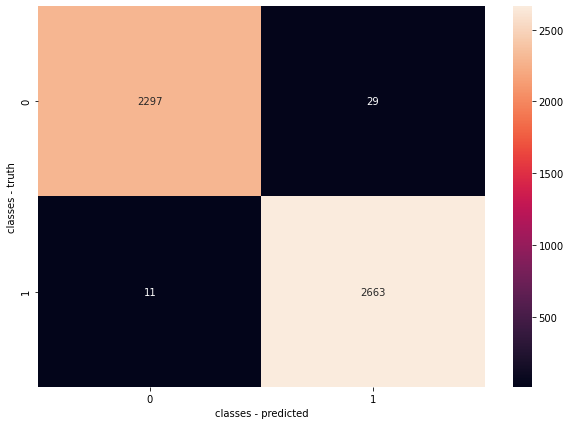

In [ ]:
yhat_nn = model_results['model'].predict(X_test)

yhat_nn[yhat_nn>0.1] = 1
yhat_nn[yhat_nn<0.1] = 0

cal_accuracy(y_test, yhat_nn)

print_confusion_matrix(y_test, yhat_nn)

### f. XGBoost

In [ ]:
X = df_merged.values
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
yhat_xg = model.predict(X_test)
cal_accuracy(y_test, yhat_xg)

Confusion Matrix: 
 [[2481   19]
 [  13 2487]]
Accuracy :  99.36
Report :                precision    recall  f1-score   support

       False       0.99      0.99      0.99      2500
        True       0.99      0.99      0.99      2500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



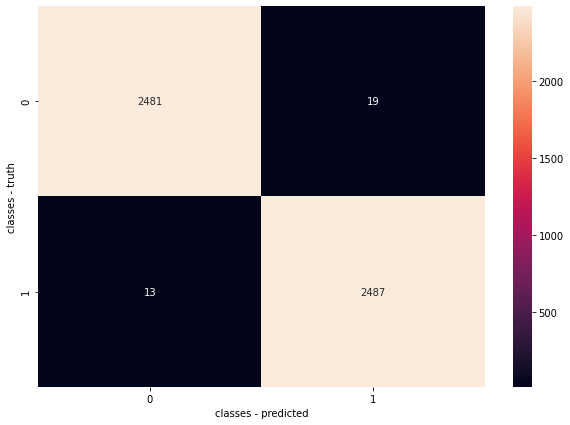

In [ ]:
print_confusion_matrix(y_test, yhat_xg)

## 6. Outcome prediction with data at a certain time of a game

In [ ]:
df_full = player_time.copy()
df_full.drop(columns = ['match_id'], inplace=True)

In [ ]:
labels = []
match_radiant_win = match['radiant_win']
match_radiant_win = match_radiant_win.to_numpy()

player_time_match = player_time['match_id']
player_time_match = player_time_match.to_numpy()

for i in range (len(player_time_match)):
    labels.append(match_radiant_win[player_time_match[i]])

In [ ]:
def create_Xy_time_t(t):
    labels = []
    match_radiant_win = match['radiant_win']
    match_radiant_win = match_radiant_win.to_numpy()
    
    temp_player_time = player_time[player_time['times'] == t].copy()
    player_time_match = temp_player_time['match_id']
    player_time_match = player_time_match.to_numpy()
    
    for i in range (len(player_time_match)):
        labels.append(match_radiant_win[player_time_match[i]])
    
    temp_player_time.drop(columns = ['match_id'], inplace=True)
    return temp_player_time.to_numpy(), labels

In [ ]:
np.unique(player_time['times'],return_counts=True)

In [ ]:
# Drop too long matches
df_trimmed = player_time.copy()
mid_to_drop = df_trimmed[df_trimmed['times'] > 3000]['match_id'].unique()
df_trimmed.drop(df_trimmed[df_trimmed['match_id'].isin(mid_to_drop)].index, inplace = True)

labels_trimmed = []
match_radiant_win = match['radiant_win']
match_radiant_win = match_radiant_win.to_numpy()

player_time_match = df_trimmed['match_id']
player_time_match = player_time_match.to_numpy()

for i in range (len(player_time_match)):
    labels_trimmed.append(match_radiant_win[player_time_match[i]])

df_trimmed_with_id = df_trimmed.copy()
df_trimmed.drop(columns = ['match_id'], inplace=True)

In [ ]:
def create_Xy_time_t_trimmed(t):
    labels = []
    match_radiant_win = match['radiant_win']
    match_radiant_win = match_radiant_win.to_numpy()
    
    temp_player_time = df_trimmed_with_id[df_trimmed_with_id['times'] == t].copy()
    player_time_match = temp_player_time['match_id']
    player_time_match = player_time_match.to_numpy()
    
    for i in range (len(player_time_match)):
        labels.append(match_radiant_win[player_time_match[i]])
    
    temp_player_time.drop(columns = ['match_id'], inplace=True)
    return temp_player_time.to_numpy(), labels

### a. Naive Bayes Model

In [ ]:
X = df_full.values
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
gnb = train_using_gaussianNB(X_train, X_test, y_train)

yhat_gnb = prediction(X_test, gnb)

In [ ]:
cal_accuracy(y_test, yhat_gnb)

In [ ]:
accuracy = np.zeros(90)
for i in range (0, 90):
    X,y = create_Xy_time_t(i*60)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
    gnb = train_using_gaussianNB(X_train, X_test, y_train)
    yhat_gnb = prediction(X_test, gnb)
    accuracy[i] = accuracy_score(y_test, yhat_gnb)

In [ ]:
x = np.linspace(0, 90, 90)

plt.scatter(x, accuracy)
plt.xlabel('time (min)')
plt.ylabel('accuracy')
plt.title('Gaussian Naive Bayes on full data')

In [ ]:
# Now on matches within 50 minutes
X = df_trimmed.values
y = labels_trimmed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
gnb = train_using_gaussianNB(X_train, X_test, y_train)

yhat_gnb = prediction(X_test, gnb)

In [ ]:
cal_accuracy(y_test, yhat_gnb)

In [ ]:
accuracy = np.zeros(50)
for i in range (0, 50):
    X,y = create_Xy_time_t(i*60)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
    gnb = train_using_gaussianNB(X_train, X_test, y_train)
    yhat_gnb = prediction(X_test, gnb)
    accuracy[i] = accuracy_score(y_test, yhat_gnb)

In [ ]:
x = np.linspace(0, 50, 50)

plt.scatter(x, accuracy)
plt.xlabel('time (min)')
plt.ylabel('accuracy')
plt.title('Gaussian Naive Bayes on trimmed data')

### b. Random Forest

In [ ]:
X = df_full.values
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
class_names = ['Dire Win', 'Radiant Win'] 
feature_names = df_full.columns

In [ ]:
rf = train_using_RF(X_train, X_test, y_train, 200)
yhat_rf = rf.predict(X_test)

In [ ]:
cal_accuracy(y_test, yhat_rf)

In [ ]:
accuracy_rf = np.zeros(90)
for i in range (0, 90):
    X,y = create_Xy_time_t(i*60)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
    rf = train_using_RF(X_train, X_test, y_train, 100)
    yhat_rf = prediction(X_test, rf)
    accuracy_rf[i] = accuracy_score(y_test, yhat_rf)

In [ ]:
x = np.linspace(0, 90, 90)

plt.scatter(x, accuracy_rf)
plt.xlabel('time (min)')
plt.ylabel('accuracy')
plt.title('Random Forest on full data')

In [ ]:
# Now on matches within 50 minutes
X = df_trimmed.values
y = labels_trimmed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
class_names = ['Dire Win', 'Radiant Win'] 
feature_names = df_trimmed.columns

In [ ]:
rf = train_using_RF(X_train, X_test, y_train, 200)
yhat_rf = rf.predict(X_test)

In [ ]:
cal_accuracy(y_test, yhat_rf)

In [ ]:
accuracy_rf = np.zeros(50)
for i in range (0, 50):
    X,y = create_Xy_time_t(i*60)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
    rf = train_using_RF(X_train, X_test, y_train, 100)
    yhat_rf = prediction(X_test, rf)
    accuracy_rf[i] = accuracy_score(y_test, yhat_rf)

In [ ]:
x = np.linspace(0, 50, 50)

plt.scatter(x, accuracy_rf)
plt.xlabel('time (min)')
plt.ylabel('accuracy')
plt.title('Random Forest on trimmed data')

## c. XGBoost

In [ ]:
X = df_full.values
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
yhat_xg = model.predict(X_test)
cal_accuracy(y_test, yhat_xg)

In [ ]:
print_confusion_matrix(y_test, yhat_xg)

In [ ]:
accuracy_xg = np.zeros(90)
for i in range (0, 90):
    X,y = create_Xy_time_t(i*60)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
    model = XGBClassifier()
    model.fit(X_train, y_train)
    yhat_xg = model.predict(X_test)
    accuracy_xg[i] = accuracy_score(y_test, yhat_xg)

In [ ]:
x = np.linspace(0, 90, 90)

plt.scatter(x, accuracy_xg)
plt.xlabel('time (min)')
plt.ylabel('accuracy')
plt.title('XGBoost on full data')

In [ ]:
# Now on matches within 50 minutes
X = df_trimmed.values
y = labels_trimmed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
yhat_xg = model.predict(X_test)
cal_accuracy(y_test, yhat_xg)

In [ ]:
print_confusion_matrix(y_test, yhat_xg)

In [ ]:
accuracy_xg = np.zeros(50)
for i in range (0, 50):
    X,y = create_Xy_time_t(i*60)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
    model = XGBClassifier()
    model.fit(X_train, y_train)
    yhat_xg = model.predict(X_test)
    accuracy_xg[i] = accuracy_score(y_test, yhat_xg)

In [ ]:
x = np.linspace(0, 50, 50)

plt.scatter(x, accuracy_xg)
plt.xlabel('time (min)')
plt.ylabel('accuracy')
plt.title('XGBoost on trimmed data')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a1ebb185-da78-4aa8-a7c7-27ce30515cc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>